In [23]:
import pandas as pd

# data = pd.read_csv("SHB_A-1987-01-02-2023-09-08.csv", sep=";", decimal=",", skiprows=1, encoding="utf-8")

# data.columns
column_order = ['Date', 'Bid', 'Ask', 'Opening price', 'High price', 'Low price', 'Closing price', 'Average price', 'Total volume', 'Turnover', 'Trades']
data = pd.read_csv("Raw_data\SHB_A-1987-01-02-2023-09-08.csv", sep=";", decimal=",", skiprows=1, usecols=column_order)

## TRANSFORM

,Closing price,Trades,Differenced Closing
Date,,,
1987-01-02,13.325,18,NaN
1987-01-05,13.325,20,0.000
1987-01-07,13.262,10,-0.063
1987-01-08,13.042,21,-0.220
1987-01-09,12.854,26,-0.188
...,...,...,...
2023-09-04,93.140,9517,1.800
2023-09-05,94.080,7826,0.940
2023-09-06,93.340,7429,-0.740


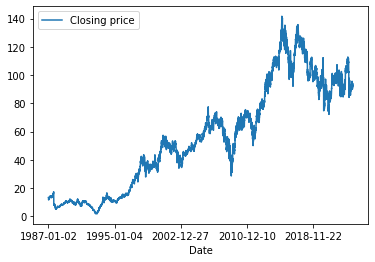

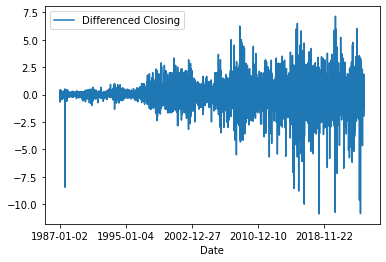

In [24]:
columns_to_drop = ["Bid", "Ask", "Opening price", "Average price"]
data = data.set_index("Date").drop(columns=columns_to_drop)

data = data.dropna(axis=1)

data = data[::-1]

data.plot.line(y="Closing price")




from statsmodels.tsa.stattools import adfuller

result = adfuller(data["Closing price"])
# if result[1] > 0.05:
    # Data is not stationary, apply differencing
data["Differenced Closing"] = data["Closing price"].diff()
    

data.plot.line(y="Differenced Closing")

data

In [25]:
PRED_HORIZON = 10
CHANGE_HORIZON = 20
FACTOR = 0.005

data["Five_day_change"] = data["Closing price"] - data["Closing price"].shift(CHANGE_HORIZON)

data["Target"] = (data["Closing price"].shift(-PRED_HORIZON) >= data["Closing price"] * (1 + FACTOR)).astype(int)

data = data.dropna()

data["Target"].value_counts()

0    4719
1    4466
Name: Target, dtype: int64

Epoch 1/20
184/184 [==============================] - 1s 2ms/step - loss: 0.6927 - accuracy: 0.5145 - val_loss: 0.6968 - val_accuracy: 0.4946
Epoch 2/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5332 - val_loss: 0.7081 - val_accuracy: 0.4973
Epoch 3/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5333 - val_loss: 0.7062 - val_accuracy: 0.5068
Epoch 4/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5308 - val_loss: 0.6990 - val_accuracy: 0.5122
Epoch 5/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5481 - val_loss: 0.7059 - val_accuracy: 0.4918
Epoch 6/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5427 - val_loss: 0.7136 - val_accuracy: 0.5041
Epoch 7/20
184/184 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5383 - val_loss: 0.7016 - val_accuracy: 0.4946
Epoch 

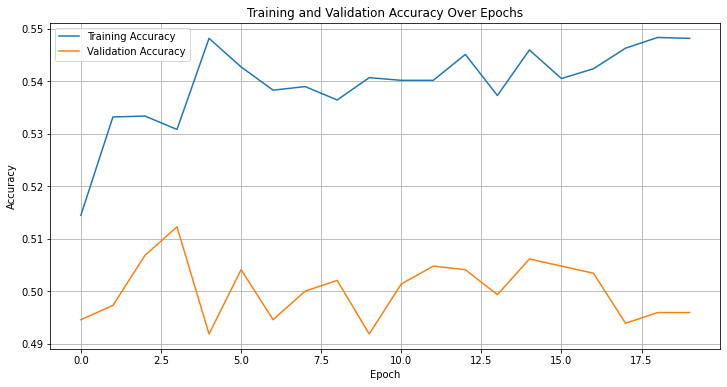

58/58 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.66      0.60      1008
           1       0.45      0.34      0.39       829

    accuracy                           0.52      1837
   macro avg       0.50      0.50      0.49      1837
weighted avg       0.51      0.52      0.50      1837

Confusion Matrix:
 [[669 339]
 [549 280]]


In [26]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

TRAIN_RATIO = 0.8

split_ix = int(len(data) * TRAIN_RATIO)

x_train = data[["Differenced Closing", "Five_day_change"]].values[:split_ix]
y_train = data["Target"].values[:split_ix]

x_test = data[["Differenced Closing", "Five_day_change"]].values[split_ix:]
y_test = data["Target"].values[split_ix:]

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
